In [1]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
# Importation du jeu de données
import pathlib
import os

2024-05-15 21:42:32.482031: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 21:42:32.485294: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 21:42:32.536420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 21:42:33.266608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# URL de l'image de Pikachu
url_pikachu = r'https://github.com/anisayari/Youtube-apprendre-le-deeplearning-avec-tensorflow/blob/master/%234%20-%20CNN/pikachu.png?raw=true' 
resp = requests.get(url_pikachu, stream=True).raw
image_array_pikachu = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_pikachu.shape}')



Shape of the image (87102,)


In [3]:
# Décodage de l'image avec OpenCV
image_pikachu = cv2.imdecode(image_array_pikachu, cv2.IMREAD_COLOR)



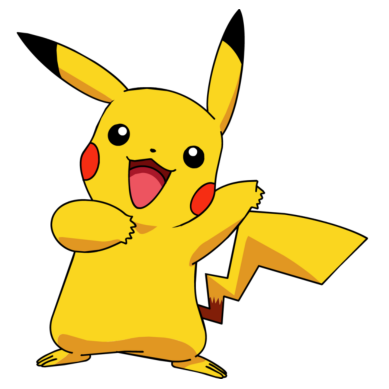

In [4]:
# Affichage de l'image avec Matplotlib
plt.axis('off')
plt.imshow(cv2.cvtColor(image_pikachu, cv2.COLOR_BGR2RGB)) # Conversion de BGR à RGB
#plt.show()



(-0.5, 39.5, 39.5, -0.5)

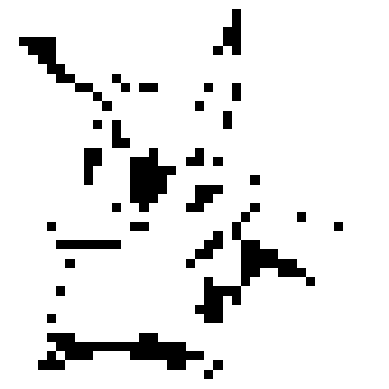

In [5]:
# Redimensionnement de l'image
res = cv2.resize(image_pikachu , dsize=(40,40), interpolation=cv2.INTER_CUBIC)

# Conversion en niveaux de gris
res = cv2.cvtColor(res,cv2.COLOR_RGB2GRAY)

# Binarisation de l'image
res = cv2.threshold(res, 127, 255, cv2.THRESH_BINARY)[1]

# Affichage de l'image binarisée
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
#plt.show()



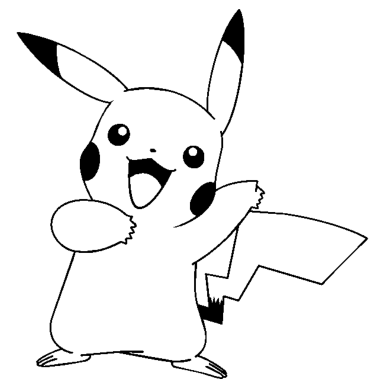

In [6]:
# Conversion de l'image en noir et blanc
img_bw = cv2.imdecode(image_array_pikachu, cv2.IMREAD_GRAYSCALE)
(thresh, img_bw) = cv2.threshold(img_bw, 127, 255, cv2.THRESH_BINARY)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_bw, cv2.COLOR_BGR2RGB))



In [7]:
# Définition du noyau pour la détection de bord vertical
kernel = np.matrix([[0,0,0],[0,1,0],[0,0,0]])
print(kernel)



[[0 0 0]
 [0 1 0]
 [0 0 0]]


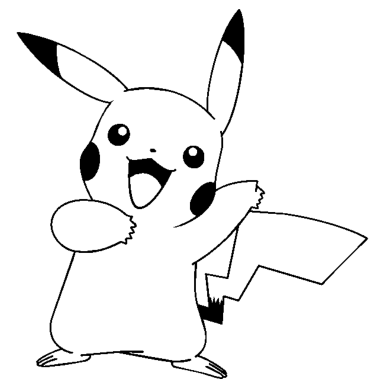

In [8]:
# Application du filtre
img_1 = cv2.filter2D(img_bw, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

In [9]:
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/anisayari/Youtube-apprendre-le-deeplearning-avec-tensorflow/blob/master/%234%20-%20CNN/dataset.zip?raw=true",
    extract=False)

#import zipfile
#with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    #zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('datasets/dataset')
print(data_dir)
print(os.path.abspath(data_dir))

datasets/dataset
/home/ssea2/datasets/dataset


In [10]:
# Comptage du nombre d'images
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

0


In [11]:
# Paramètres pour la création des ensembles de données
batch_size = 3
img_height = 200
img_width = 200

# Création des ensembles de données d'entraînement et de validation
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Noms de classe
class_names = val_data.class_names
print(class_names)

NotFoundError: Could not find directory datasets/dataset

In [ ]:

# Affichage des images d'exemple
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
layers=tf.keras.layers

# Définition du modèle CNN
num_classes = 2
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)

In [ ]:
# Callback pour TensorBoard
logdir="logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                   embeddings_data=train_data)

In [ ]:

# Entraînement du modèle
model.fit( 
    train_data,
    validation_data=val_data,
    epochs=2,
    callbacks=[tensorboard_callback]
)

In [ ]:

# Fonction pour afficher les filtres de convolution
def display_filter(model, layer_name):
    layer = model.get_layer(layer_name)
    filter, bias= layer.get_weights()
    dim = filter.shape[3]
    print(f'{layer_name} | Filter Shape: {filter.shape} Bias Shape: {bias.shape}')
    print(f'Dimension {dim}')
    f_min, f_max = filter.min(), filter.max()
    filter = (filter - f_min) / (f_max - f_min)
    print(filter.shape)
    fig= plt.figure(figsize=(30,30))
    for i in range(dim):
        ax = fig.add_subplot(dim/2,dim/2,i+1)
        ax.axis('off')
        try:
            ax.imshow(filter[:,:,:,i])
        except:
            ax.imshow(filter[:,:,:,i][0])

# Affichage des filtres de convolution
display_filter(model,f'conv2d_{num}')